# Langchain, context + user prompt

In [39]:
import os
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
import time

from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_KEY')

In [40]:
# define the context and user prompt
context = "In a hidden village, ninjas train to protect their homeland from evil forces."
user_prompt = "write a fairy tale about ninjas"

In [41]:
# create the prompt template with placeholders
prompt_template = ChatPromptTemplate.from_template(
    "You are a helpful assistant who writes new fairy tales. \
    For this, you will receive a user prompt and a context from a RAG system. \
    With these inputs, create a new fairy tale for a child.\n"
    "User prompt: {user_prompt}\n"
    "Context: {context}\n"
)

# initialize the llm model
llm = ChatOpenAI(model_name="gpt-4")

# create a chain with the prompt template and the model
chain = LLMChain(prompt=prompt_template, llm=llm)


In [64]:
# run the chain with the context and user prompt variables
response = chain.invoke({"context": context, "user_prompt": user_prompt})

In [43]:
print(response['text'])

Title: The Tale of the Silent Shadows

Once upon a time, in a village hidden deep within the mountains, shrouded by mist and mystery, lived a community of skilled warriors. These were no ordinary warriors; they were ninjas, the Silent Shadows of the Hidden Leaf Village.

The ninjas were the protectors of their homeland, training from dawn to dusk, perfecting their stealth, speed, and strength. They were not just warriors, but also the guardians of peace, harmony, and balance. They were the invisible force keeping the village safe from evil forces lurking beyond the mountains.

The most skilled among them was a young ninja named Hiroki. Hiroki was known for his exceptional skills and his keen sense of justice. He was swift as the wind and silent as a falling leaf. Even though he was young, Hiroki was respected by all for his dedication and commitment to the well-being of the Hidden Leaf Village.

One day, an ominous darkness fell over the village. It was the evil sorcerer, Oni, who hung

# Prompt techniques (Query translation):

## Step back

**Pros**: 

Si l'usuari demana un conte molt específic pot ser que trobi poques semblances a la Vectordb. Fent la request més abstracta permet obtenir més context des de la vector db i al pasar els dos contexts no perdem informació en el cas de que trobi informació rellevant de la pregunta més concreta.

**Cons**:

Tarda més temps per a crear el conte ja que ha d'esperar el primer request al llm

![](./stepback.PNG)

In [57]:
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

In [54]:

examples = [
    {
        "input": "Can you write a fairy tale about a brave little toaster that comes to life after being abandoned in a cabin and embarks on a perilous journey to find their owner, having different adventures during the journey?",
        "output": "Can you write a fairy tale about a brave little toaster?",
    },
    {
        "input": "Can you write a fairy tale about an ordinary boy named Harry Potter that lives a miserable life with his dreadful aunt, uncle, and spoiled cousin? On his eleventh birthday, his world is turned upside down when he learns he's a powerful wizard and must attend Hogwarts School of Witchcraft and Wizardry. There, he embarks on a magical adventure filled with friendship, danger, and the truth about his mysterious past.",
        "output": "Can you write a fairy tale about an unloved orphan who discovers a hidden world of magic and embarks on a journey of self-discovery, facing a powerful enemy and forging lifelong friendships?",
    },
]

# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase 
            a description of a request for a fairy tale to a more generic step-back request,
            which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)


In [55]:
generate_queries_step_back = prompt | ChatOpenAI(temperature=0) | StrOutputParser()
question = "Write a history about a young boy who discovers an alien stranded on Earth. The boy and his siblings befriend the gentle creature and keep him hidden from authorities. As they form a deep bond, they work to help the alien contact his home planet. Despite challenges and government interference, they eventually succeed in sending the alien back home."
generate_queries_step_back.invoke({"question": question})

'Can you write a story about a young boy who befriends a stranded alien on Earth and helps him return to his home planet, facing obstacles and forming a strong bond along the way?'

Get the context from the vector db

In [68]:
general_context = "Picture a young lad stumbling upon an extraterrestrial visitor marooned amidst the earthly soil. With secrecy as their ally, the lad and his kin embrace the alien as kin, shielding it from prying eyes. Their bond, like stitches in a quilt, grows tighter as they embark on a quest to reunite the lost wanderer with its celestial home. Amidst trials and tribulations, they persevere, ultimately guiding their otherworldly friend back to the stars whence it came."
original_context = "Set in suburban California, the story begins when a gentle and curious alien is accidentally left behind by his spaceship during a reconnaissance mission on Earth. This stranded visitor, affectionately named E.T., finds refuge in a tool shed where he is discovered by a young boy named Elliott.What follows is a heartwarming tale of friendship and adventure as Elliott and his siblings form an emotional bond with the alien creature. Despite their initial fears and uncertainties, they quickly realize that E.T. is a being of immense kindness and intelligence. Together, they embark on a journey to help E.T. return home, all while keeping his existence hidden from the authorities and scientists who seek to capture him for study. As their bond deepens, E.T. demonstrates remarkable abilities, including telekinesis and the power to heal. These supernatural talents serve as a source of wonder and awe for Elliott and his friends, but also attract unwanted attention from government agents who are determined to capture the alien at any cost. Throughout the film, themes of friendship, loyalty, and empathy are woven into the narrative, highlighting the universal human experience of connection and understanding. As Elliott and E.T. form an unbreakable bond, they teach each other valuable lessons about love, courage, and the importance of belonging. The climax of the film comes as E.T. becomes increasingly ill, his connection to Elliott weakening as a result of their physical and emotional separation. In a race against time, Elliott and his friends band together to help E.T. build a makeshift communication device using household objects, with the hope of contacting his fellow aliens and arranging for his rescue. In a heart-wrenching finale, E.T. bids farewell to his human friends and boards his spaceship, leaving behind memories of their unforgettable adventure together. As he soars into the night sky, E.T. reminds us of the enduring power of friendship and the boundless possibilities of the universe."

In [69]:
# create the prompt template with placeholders
prompt_template = ChatPromptTemplate.from_template(
    "You are a helpful assistant who writes new fairy tales. \
    For this, you will receive a user prompt and two context from a RAG system. \
    With these inputs, create a new fairy tale for a child. The fairy tale has to have consistency\
    and be suitable for children. \n"
    "User prompt: {question}\n"
    "Context_1: {general_context}\n"
    "Context_2: {original_context}\n"

)

# initialize the llm model
llm = ChatOpenAI(model_name="gpt-4")

# create a chain with the prompt template and the model
chain = LLMChain(prompt=prompt_template, llm=llm)

In [71]:
# run the chain with the context and user prompt variables
response = chain.invoke({"general_context": general_context, "original_context": original_context, "question":question})
print(response['text'])

Once upon a time, in the quiet suburbs of California, a young boy named Sam and his siblings, Lila and Tim, made an extraordinary discovery. Within the dusty confines of their old tool shed, they found an alien creature, lost and far away from home. He was a gentle soul, with a heart as vast as his home in the cosmos. They named him Zephyr, for he was as mysterious and enchanting as the evening breeze.

The children, intrigued and compassionate, welcomed Zephyr into their home. They hid him from their parents' watchful eyes and the prying gaze of the outside world. Their bond was stitched together with secrets and shared laughter, a patchwork of moments that grew stronger with each passing day.

Zephyr, despite his alien origin, was a creature of immense kindness and intelligence. The children were captivated by his abilities, which were unlike anything they had ever seen. He could move objects with his mind and heal the smallest injuries with a mere touch of his hands. These talents b

# Query Construction
## Hyde


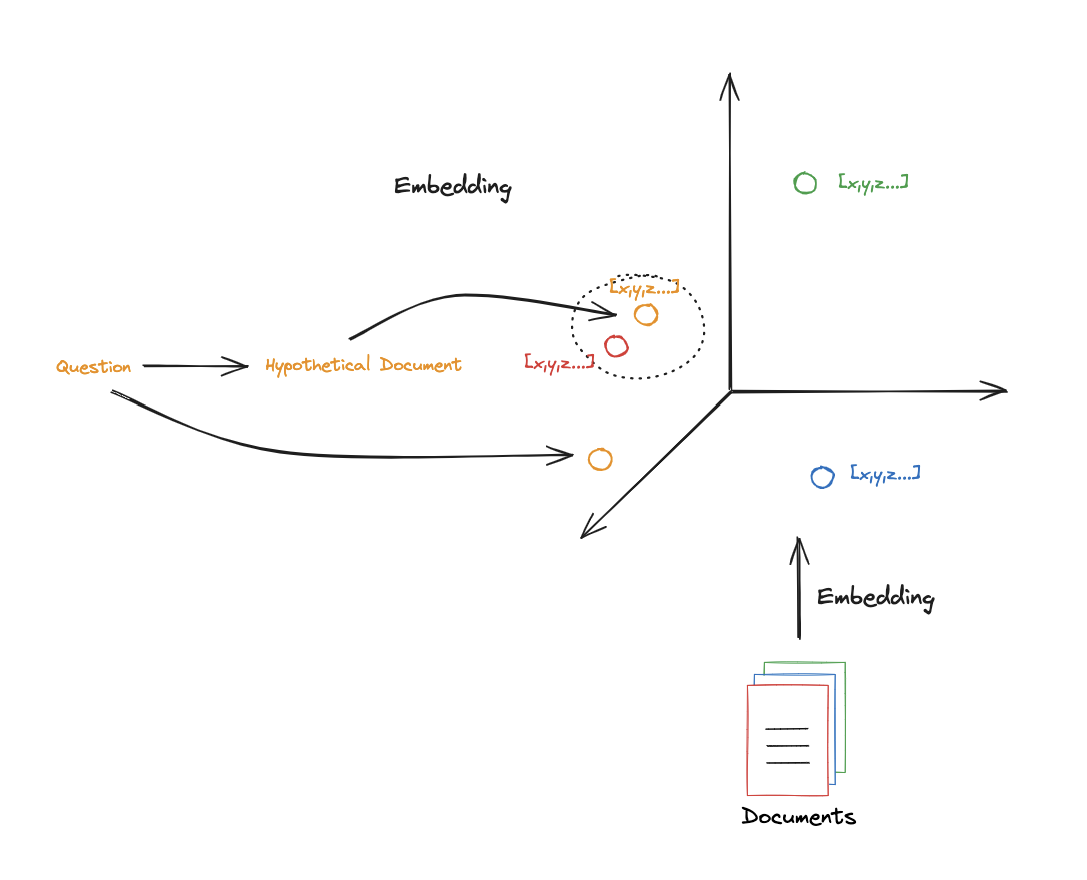

Docs:

    https://github.com/langchain-ai/langchain/blob/master/cookbook/hypothetical_document_embeddings.ipynb

Paper:

    https://arxiv.org/abs/2212.10496


**Pros**: 

Afavoreix a trobar més similaritats a la vector db 
    
**Cons**:

Tarda més temps per a crear el conte ja que ha d'esperar el primer request al llm

In [73]:
from langchain.prompts import ChatPromptTemplate

# HyDE document genration
template = """You are a helpful assistant who writes new fairy tales. \
    For this, you will receive a user prompt. \
    Create a new fairy tale, it has to have consistency\
    and be suitable for children. \n
Question: {question}
Fairy tale:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_docs_for_retrieval = (
    prompt_hyde | ChatOpenAI(temperature=0) | StrOutputParser()
)

# Run
question = "write a fairy tale about ninjas"
generate_docs_for_retrieval.invoke({"question":question})

"Once upon a time in a faraway land, there lived a group of ninjas who were known for their incredible skills and stealth. These ninjas were not like any other, for they used their powers for good and to protect the innocent.\n\nThe leader of the ninjas was a wise and brave warrior named Sensei Hiro. He trained his students diligently, teaching them the ways of the ninja and instilling in them the values of honor, courage, and compassion.\n\nOne day, a dark and powerful sorcerer named Malakar descended upon the village, spreading fear and chaos wherever he went. The ninjas knew they had to stop him before he could do any more harm.\n\nWith their ninja skills and cunning tactics, the ninjas set out to defeat Malakar and restore peace to the land. They faced many challenges and obstacles along the way, but they never gave up.\n\nIn the final battle, Sensei Hiro and his ninjas confronted Malakar in a fierce showdown. The sorcerer unleashed his dark magic, but the ninjas fought bravely, us

In [ ]:
# Retrieve to vector db
#retrieval_chain = generate_docs_for_retrieval | retriever


In [75]:
# output of vector db
fairy_tale_context = "Picture a young lad stumbling upon an extraterrestrial visitor marooned amidst the earthly soil. With secrecy as their ally, the lad and his kin embrace the alien as kin, shielding it from prying eyes. Their bond, like stitches in a quilt, grows tighter as they embark on a quest to reunite the lost wanderer with its celestial home. Amidst trials and tribulations, they persevere, ultimately guiding their otherworldly friend back to the stars whence it came."
original_context = "Set in suburban California, the story begins when a gentle and curious alien is accidentally left behind by his spaceship during a reconnaissance mission on Earth. This stranded visitor, affectionately named E.T., finds refuge in a tool shed where he is discovered by a young boy named Elliott.What follows is a heartwarming tale of friendship and adventure as Elliott and his siblings form an emotional bond with the alien creature. Despite their initial fears and uncertainties, they quickly realize that E.T. is a being of immense kindness and intelligence. Together, they embark on a journey to help E.T. return home, all while keeping his existence hidden from the authorities and scientists who seek to capture him for study. As their bond deepens, E.T. demonstrates remarkable abilities, including telekinesis and the power to heal. These supernatural talents serve as a source of wonder and awe for Elliott and his friends, but also attract unwanted attention from government agents who are determined to capture the alien at any cost. Throughout the film, themes of friendship, loyalty, and empathy are woven into the narrative, highlighting the universal human experience of connection and understanding. As Elliott and E.T. form an unbreakable bond, they teach each other valuable lessons about love, courage, and the importance of belonging. The climax of the film comes as E.T. becomes increasingly ill, his connection to Elliott weakening as a result of their physical and emotional separation. In a race against time, Elliott and his friends band together to help E.T. build a makeshift communication device using household objects, with the hope of contacting his fellow aliens and arranging for his rescue. In a heart-wrenching finale, E.T. bids farewell to his human friends and boards his spaceship, leaving behind memories of their unforgettable adventure together. As he soars into the night sky, E.T. reminds us of the enduring power of friendship and the boundless possibilities of the universe."

In [77]:
# create the prompt template with placeholders
prompt_template = ChatPromptTemplate.from_template(
    "You are a helpful assistant who writes new fairy tales. \
    For this, you will receive a user prompt and two context from a RAG system. \
    With these inputs, create a new fairy tale for a child. The fairy tale has to have consistency\
    and be suitable for children. \n"
    "User prompt: {question}\n"
    "Context_1: {fairy_tale_context}\n"
    "Context_2: {original_context}\n"

)

# initialize the llm model
llm = ChatOpenAI(model_name="gpt-4")

# create a chain with the prompt template and the model
chain = LLMChain(prompt=prompt_template, llm=llm)

In [78]:
# run the chain with the context and user prompt variables
response = chain.invoke({"fairy_tale_context": fairy_tale_context, "original_context": original_context, "question":question})
print(response['text'])

Once upon a time, in the bustling city of Tokyo, a young lad named Hiro stumbled upon a mysterious visitor, not from another country, but from another universe. This visitor, a Ninja from the celestial Ninja Star Clan, had been accidentally left behind by his spaceship during a celestial battle on Earth. This stranded Ninja, whom Hiro affectionally named 'Shinobi', found refuge in Hiro's tool shed.

The bond between Hiro and Shinobi grew with each passing day, much like a well-tempered Katana. Despite their different worlds, they found kinship in their shared love for adventure. They realized that Shinobi, with his black Ninja outfit and swift moves, was not only intelligent but also immensely kind. He had a heart as pure as gold despite his fierce appearance.

From the very beginning, Hiro and his friends had pledged secrecy, knowing that if the authorities or scientists discovered Shinobi, they would attempt to capture him for study. As Shinobi demonstrated remarkable abilities like 